In [1]:
import numpy as np
import pandas as pd

from scipy.stats import ks_2samp, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import friedmanchisquare, anderson_ksamp

In [2]:
np.random.seed(42) 

n_days = 30
n_samples_per_day = 1000
n_drifts = 10

dates = pd.date_range(start='2023-01-01', periods=n_days, freq='D')

df = pd.DataFrame({
    'date': np.repeat(dates, n_samples_per_day),
    'value1': np.zeros(n_days * n_samples_per_day),
    'value2': np.zeros(n_days * n_samples_per_day),
    'value3': np.zeros(n_days * n_samples_per_day),
    'value4': np.zeros(n_days * n_samples_per_day),
    'value5': np.zeros(n_days * n_samples_per_day),
})

In [3]:
drift_days = np.random.choice(n_days, n_drifts, replace=False)

In [4]:
sorted(drift_days)

[0, 8, 9, 12, 15, 17, 23, 24, 27, 28]

In [5]:
values1, values2, values3, values4, values5 = [], [], [], [], []
for day in range(n_days):
    if day in drift_days:
        values1.extend(np.random.normal(loc=1, scale=1.5, size=n_samples_per_day))
        values2.extend(np.random.exponential(scale=2, size=n_samples_per_day))
        values3.extend(np.random.poisson(lam=3, size=n_samples_per_day))
        values4.extend(np.random.binomial(n=10, p=0.5, size=n_samples_per_day))
        values5.extend(np.random.beta(a=2, b=5, size=n_samples_per_day))
    else:
        values1.extend(np.random.normal(loc=0, scale=1, size=n_samples_per_day))
        values2.extend(np.random.exponential(scale=1, size=n_samples_per_day))
        values3.extend(np.random.poisson(lam=1, size=n_samples_per_day))
        values4.extend(np.random.binomial(n=10, p=0.3, size=n_samples_per_day))
        values5.extend(np.random.beta(a=5, b=1, size=n_samples_per_day))

df_corrected = pd.DataFrame({
    'date': np.repeat(dates, n_samples_per_day),
    'value1': values1,
    'value2': values2,
    'value3': values3,
    'value4': values4,
    'value5': values5,
})

df_corrected['combo1'] = df_corrected['value1'] + df_corrected['value2']
df_corrected['combo2'] = df_corrected['value3'] - df_corrected['value4']
df_corrected['combo3'] = df_corrected['value1'] * df_corrected['value5']
df_corrected['combo4'] = df_corrected['value2'] / df_corrected['value3'].replace(0, 1)
df_corrected['combo5'] = (df_corrected['value4'] + df_corrected['value5']) / 2
df = df_corrected

In [6]:
days = df['date'].unique()
n_days = len(days)

ks_p_matrix = np.ones((n_days, n_days)) 
mwu_p_matrix = np.ones((n_days, n_days))

In [7]:
%%time

for i, day1 in enumerate(days):
    for j, day2 in enumerate(days):
        if i < j: 
            data1 = df[df['date'] == day1]['value4']
            data2 = df[df['date'] == day2]['value4']    
            
            _, ks_p = ks_2samp(data1, data2)
            ks_p_matrix[i, j] = ks_p_matrix[j, i] = ks_p

            _, mwu_p = mannwhitneyu(data1, data2, alternative='two-sided')
            mwu_p_matrix[i, j] = mwu_p_matrix[j, i] = mwu_p


ks_p_values = ks_p_matrix[np.triu_indices(n_days, 1)]
mwu_p_values = mwu_p_matrix[np.triu_indices(n_days, 1)]

_, ks_p_corrected_bonf = multipletests(ks_p_values, method='bonferroni')[:2]
_, mwu_p_corrected_bonf = multipletests(mwu_p_values, method='bonferroni')[:2]

_, ks_p_corrected_bh = multipletests(ks_p_values, method='fdr_bh')[:2]
_, mwu_p_corrected_bh = multipletests(mwu_p_values, method='fdr_bh')[:2]

ks_p_matrix_corrected_bonf = np.ones((n_days, n_days))
mwu_p_matrix_corrected_bonf = np.ones((n_days, n_days))
ks_p_matrix_corrected_bh = np.ones((n_days, n_days))
mwu_p_matrix_corrected_bh = np.ones((n_days, n_days))

def fill_upper_triangular(matrix, values):
    indices = np.triu_indices_from(matrix, k=1)
    matrix[indices] = values
    matrix[indices[::-1]] = values 

fill_upper_triangular(ks_p_matrix_corrected_bonf, ks_p_corrected_bonf)
fill_upper_triangular(mwu_p_matrix_corrected_bonf, mwu_p_corrected_bonf)
fill_upper_triangular(ks_p_matrix_corrected_bh, ks_p_corrected_bh)
fill_upper_triangular(mwu_p_matrix_corrected_bh, mwu_p_corrected_bh)

C:\Users\vasil\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


CPU times: total: 1.09 s
Wall time: 1.77 s


In [8]:
def plot_heatmap(matrix, title, ax):
    sns.heatmap(matrix, cmap='viridis', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Day')
    ax.set_ylabel('Day')

In [9]:
sorted(drift_days)

[0, 8, 9, 12, 15, 17, 23, 24, 27, 28]

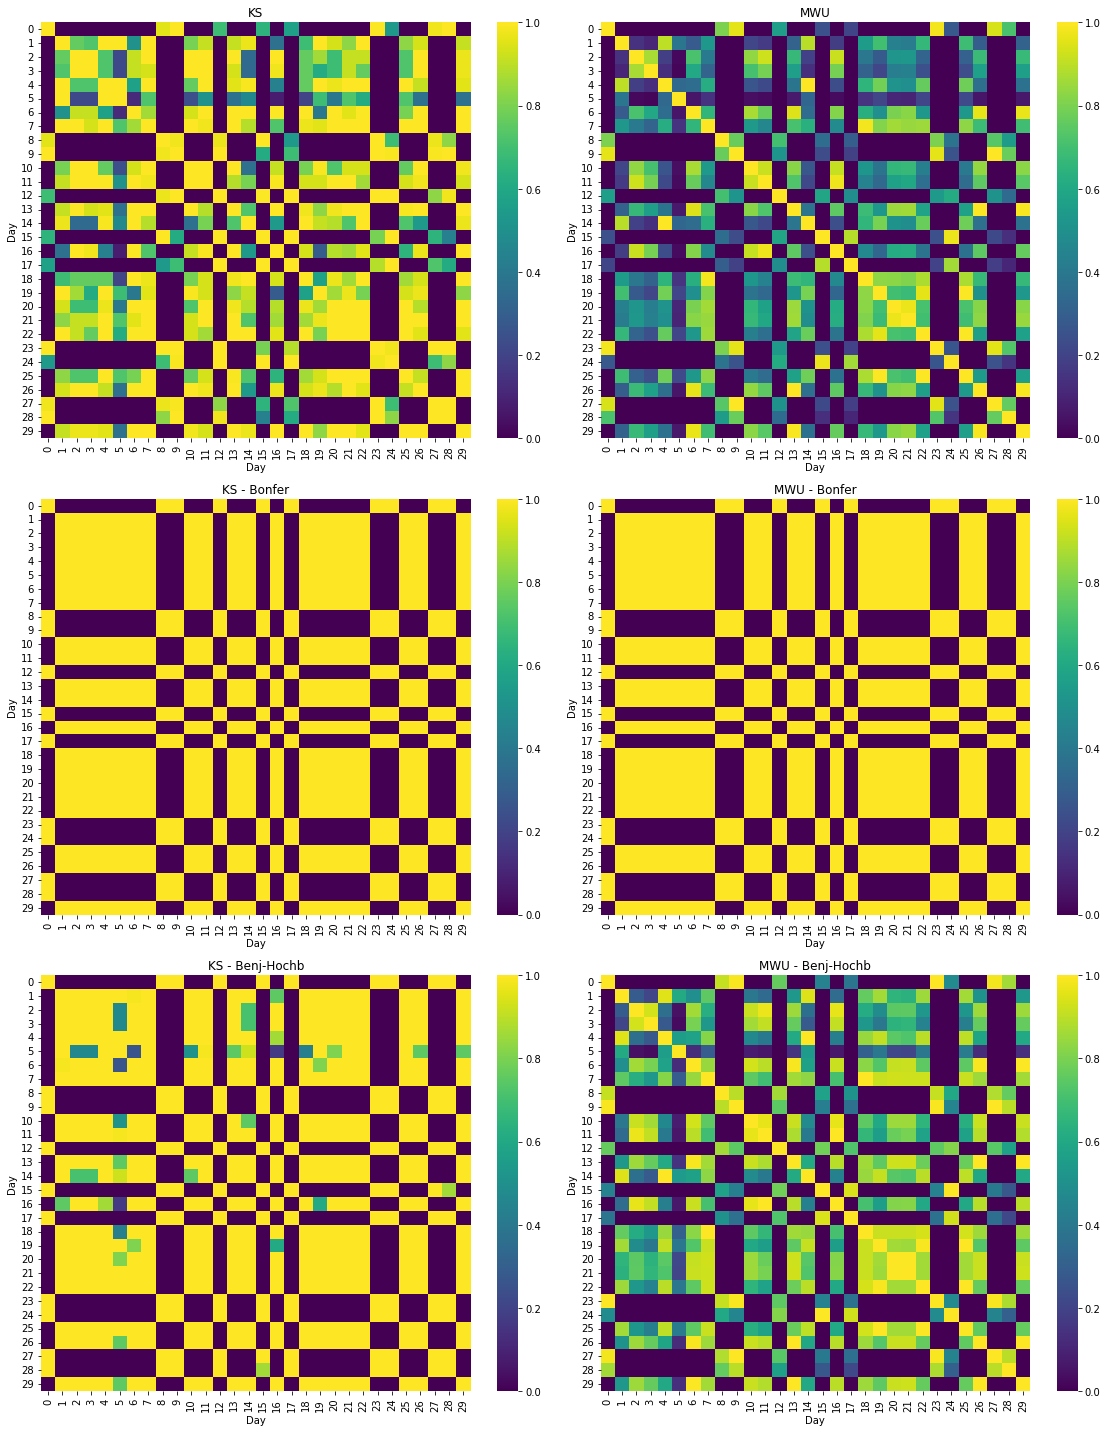

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(16, 20))

plot_heatmap(ks_p_matrix, 'KS', axs[0, 0])
plot_heatmap(mwu_p_matrix, 'MWU', axs[0, 1])

plot_heatmap(ks_p_matrix_corrected_bonf, 'KS - Bonfer', axs[1, 0])
plot_heatmap(mwu_p_matrix_corrected_bonf, 'MWU - Bonfer', axs[1, 1])

plot_heatmap(ks_p_matrix_corrected_bh, 'KS - Benj-Hochb', axs[2, 0])
plot_heatmap(mwu_p_matrix_corrected_bh, 'MWU - Benj-Hochb', axs[2, 1])

plt.tight_layout()
plt.show()

In [11]:
window_size = 5 
n_days = len(days)

friedman_stats = []
anderson_stats = []

significant_changes = []

In [12]:
for i in range(n_days - window_size + 1):
    window_days = days[i:i + window_size]
    samples = [df[df['date'] == day]['value1'] for day in window_days]

    try:
        friedman_stat, _ = friedmanchisquare(*samples)
    except ValueError as e:
        friedman_stat = np.nan

    friedman_stats.append(friedman_stat)

    try:
        anderson_stat, _, _ = anderson_ksamp(samples)
    except ValueError as e:
        anderson_stat = np.nan

    anderson_stats.append(anderson_stat)

    if i > 0 and (np.isnan(anderson_stat) or abs(anderson_stat - anderson_stats[i-1]) > 20):
        significant_changes.append(window_days[-1])
        
print("Significant changes detected on days:", significant_changes)

C:\Users\vasil\AppData\Local\Temp\ipykernel_25588\3143216525.py:13: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_stat, _, _ = anderson_ksamp(samples)
C:\Users\vasil\AppData\Local\Temp\ipykernel_25588\3143216525.py:13: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  anderson_stat, _, _ = anderson_ksamp(samples)


Significant changes detected on days: [numpy.datetime64('2023-01-06T00:00:00.000000000'), numpy.datetime64('2023-01-09T00:00:00.000000000'), numpy.datetime64('2023-01-10T00:00:00.000000000'), numpy.datetime64('2023-01-14T00:00:00.000000000'), numpy.datetime64('2023-01-15T00:00:00.000000000'), numpy.datetime64('2023-01-16T00:00:00.000000000'), numpy.datetime64('2023-01-21T00:00:00.000000000'), numpy.datetime64('2023-01-23T00:00:00.000000000'), numpy.datetime64('2023-01-24T00:00:00.000000000'), numpy.datetime64('2023-01-25T00:00:00.000000000'), numpy.datetime64('2023-01-28T00:00:00.000000000')]
